# Text Classification

Text classification is the process of assigning tags or categories to text according to its content. It’s one of the fundamental tasks in natural language processing. 

The text we wanna classify is given as input to an algorithm, the algorithm will then analyze the text’s content, and then categorize the input as one of the tags or categories previously given.

**Input → Classifying Algorithm → Classification of Input**

Real life examples: 

+ sentiment analysis: how does the writer of the sentence feel about what they are writing about, do they think positively or negatively of the subject?Ex. restaurant reviews
+ topic labeling: given sentences and a set of topics, which topic does this sentence fall under?  Ex. is this essay about history? Math? etc?
+ spam detection. Ex. Email filtering: is this email a real important email or spam?

Example. 
A restaurant wants to evaluate their ratings but don’t want to read through all of them. Therefore, they wanna use a computer algorithm to do all their work. They simply want to know if the customer’s review is positive or negative.

Here’s an example of a customer’s review and a simple way an algorithm could classify their review.

Input: “The food here was too salty and too expensive” 

Algorithm: 
Goes through every word in the sentence and counts how many positive words and how many negative words are in the sentence.

		“The, food, here, was, too, and” are all neutral words

		“Salty, expensive” are negative words.

		Negative words: 2
		Positive words: 0

Classification: Negative Review, because there are more negative words (2) than positive (0).

However, this algorithm obviously doesn’t work in a lot of cases. 

For example, “The food here was good, not expensive and not salty” would be classified as negative but it’s actually a positive review. 

Language and text can get very complicated which makes creating these algorithms difficult. Some things that make language difficult could be words that have multiple meanings, negation words (words such as not), slang, etc.



## Importing Data

In [1]:
import sys
import string
from scipy import sparse
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from IPython.display import display
import ipywidgets as widgets

from pprint import pprint
import seaborn as sns
import pandas as pd

# Adding some comment explanations...

# Our input files, divided into a training and test  set
trainingFile = "dataset/trainingSet.txt"
testingFile = "dataset/testSet.txt"

In [2]:
# Takes a filename string as input, and divides them into arrays containing the sentences, and their related sentiments.
def getData(fileName):
    f = open(fileName)
    file = f.readlines()

    sentences = []
    sentiments = []

    for line in file:
        sentence, sentiment = line.split('\t')
        sentences.append(sentence.strip())
        sentiments.append(int(sentiment.strip())) # Sentiment in {0,1}

    return sentences, np.array(sentiments)

In [3]:
trainingSentences, trainingLabels = getData(trainingFile)
testingSentences, testingLabels = getData(testingFile)

print("Training Sentence Sample: ")
pprint(trainingSentences[:10])
print("Training Label Sample: ")
pprint(trainingLabels[:10])
print("Testing Sentence Sample: ")
pprint(testingSentences[:10])
print("Testing Label Sample: ")
pprint(testingLabels[:10])

Training Sentence Sample: 
['Wow... Loved this place.',
 'Not tasty and the texture was just nasty.',
 'Stopped by during the late May bank holiday off Rick Steve recommendation '
 'and loved it.',
 'The selection on the menu was great and so were the prices.',
 'Now I am getting angry and I want my damn pho.',
 "Honeslty it didn't taste THAT fresh.)",
 'The potatoes were like rubber and you could tell they had been made up ahead '
 'of time being kept under a warmer.',
 'The fries were great too.',
 'A great touch.',
 'Service was very prompt.']
Training Label Sample: 
array([1, 0, 1, 1, 0, 0, 0, 1, 1, 1])
Testing Sentence Sample: 
['Crust is not good.',
 'Would not go back.',
 'I was shocked because no signs indicate cash only.',
 'The food, amazing.',
 'Service is also cute.',
 'I could care less... The interior is just beautiful.',
 'So they performed.',
 'This hole in the wall has great Mexican street tacos, and friendly staff.',
 'The worst was the salmon sashimi.',
 'Also there 

## Pre-Processing Data

In [4]:
# Various grammar elements which have no sentence effect are removed
def cleanText(sentence):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

# Cleaning up text and tokenizing sentences. 
def preProcess(text):
    # Make lower case
    text = text.lower()

    # Replace non-text characters with spaces
    nonText = string.punctuation + ("")
    text = text.translate(str.maketrans(nonText, ' ' * (len(nonText))))

    # Tokenize
    words = text.split()

    return words

    #return list(map(cleanText, sentences))

Percentage Negative:  0.4909819639278557
Percentage Positive:  0.5090180360721442


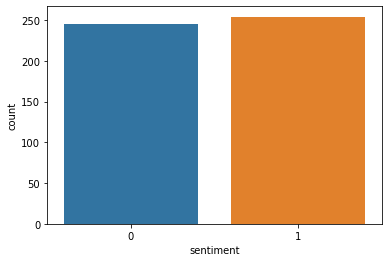

In [5]:
train_sentence = []
train_words = []
test_sentence = []
# Note, test_words is currently un-used in the rest of the code
test_words = []
# get cleaned sentences and bag of words
for sen in trainingSentences:
    train_sentence.append(cleanText(sen))
    train_words.append(preProcess(sen))
for sen in testingSentences:
    test_sentence.append(cleanText(sen))
    test_words.append(preProcess(sen))
    
# Pre-processed sets of words / sentences are hereby referred to using the array
# variables above. 

train_df = pd.DataFrame(data=trainingLabels, columns=["sentiment"])
sns.countplot(x='sentiment', data=train_df)
print("Percentage Negative: ", train_df["sentiment"].value_counts()[0] / train_df["sentiment"].count())
print("Percentage Positive: ", train_df["sentiment"].value_counts()[1] / train_df["sentiment"].count())

## Getting Data and Setting it Up

In [6]:
# Importing ML Libraries
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from keras.callbacks import Callback

from numpy import array
from numpy import asarray
from numpy import zeros

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

# Turning 2d word arrays into set of vocab words
def getVocab(sentences):
    vocab = set()
    for sentence in sentences:
        for word in sentence:
            vocab.add(word)
    return sorted(vocab)

vocabulary = getVocab(train_words)

In [7]:
def clicked(arg):
    print(vocabulary)

button_download = widgets.Button(description = 'Click to see Vocab')   
button_download.on_click(clicked)
display(button_download)

Button(description='Click to see Vocab', style=ButtonStyle())

In [8]:
# Function is currently uncalled in code
def createVector(vocab, sentences):
    indices = []
    wordOccurrences = []

    for sentenceIndex, sentence in enumerate(sentences):
        alreadyCounted = set() # Keep track of words so we don't double count.
        for word in sentence:
            if (word in vocab) and word not in alreadyCounted:
                # If we just want {0,1} for the presence of the word (bernoulli NB),
                # only count each word once. Otherwise (multinomial NB) count each
                # occurrence of the word.
                
            
                #which sentence, which word
                indices.append((sentenceIndex, vocab.index(word)))
                
                wordOccurrences.append(1)
                alreadyCounted.add(word)

    # Unzip
    rows = [row for row, _ in indices]
    columns = [column for _, column in indices]

    sentenceVectors = sparse.csr_matrix((wordOccurrences, (rows, columns)), dtype=int, shape=(len(sentences), len(vocab)))

    return sentenceVectors

In [9]:
# Tokenizer creates a dictionary of used words in training,
# keeping the 2000 most frequent.
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(train_sentence)

# Sentences are then converted into sequences of indeces which correspond to
# our dictionary created above
X_train = tokenizer.texts_to_sequences(train_sentence)
X_test = tokenizer.texts_to_sequences(test_sentence)
# print(X_train)

In [10]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1 # Use num_words variable? 

maxlen = 10

# Index Sequence sentences have zeroes added or are truncated to make all
# sentences of length 'maxlen'. Purpose is to create uniform data for the
# embedding layer later on. 
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
y_train = trainingLabels
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
y_test = testingLabels

In [11]:


class ConfMatrixCallbackPlotter(Callback):
    def __init__(self, model, validation_data):
        super().__init__()
        self.model = model
        self.validation_data = validation_data
        
    def on_epoch_end(self, epoch, logs={}):
        # Using same prediction as below section
        y_prediction = np.asarray((self.model.predict(self.validation_data[0])) > 0.5).astype("int32")
        y_hat_probabilities = self.model.predict(self.validation_data[0] > 0.5, batch_size=128)
        
        data = {'Actual':    self.validation_data[1],
                'Predicted': y_prediction.reshape(len(self.validation_data[1]),)
        }
        
        df = pd.DataFrame(data, columns=['Actual','Predicted'])
        confusion_matrix = pd.crosstab(df['Actual'], df['Predicted'], rownames=['Actual'], colnames=['Predicted'])

        sns.heatmap(confusion_matrix, annot=True,cmap="YlGnBu", fmt='d').set_title('Confusion Matrix of Testing')
        plt.show()
        
#         y_true = self.validation_data[1]             
#         y_pred_class = np.argmax(y_prediction, axis=1)
#         print("End epoch {} of training.".format(epoch))
#         print(df)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           133200    
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1001      
Total params: 134,201
Trainable params: 1,001
Non-trainable params: 133,200
_________________________________________________________________
None
Epoch 1/20


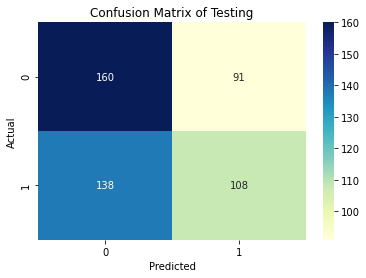

4/4 - 0s - loss: 0.6927 - acc: 0.5130 - val_loss: 0.6914 - val_acc: 0.5392
Epoch 2/20


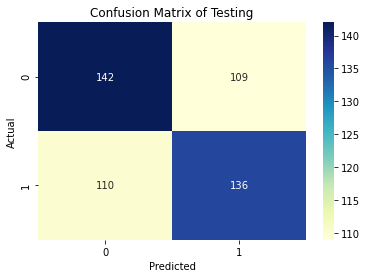

4/4 - 0s - loss: 0.6912 - acc: 0.5391 - val_loss: 0.6911 - val_acc: 0.5594
Epoch 3/20


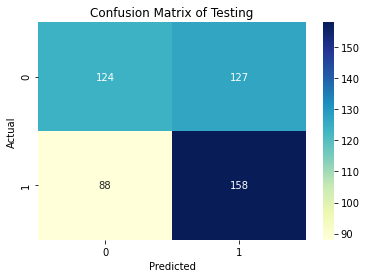

4/4 - 0s - loss: 0.6900 - acc: 0.5591 - val_loss: 0.6909 - val_acc: 0.5674
Epoch 4/20


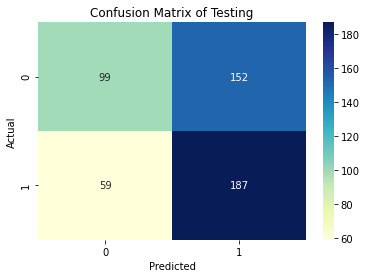

4/4 - 0s - loss: 0.6888 - acc: 0.5792 - val_loss: 0.6906 - val_acc: 0.5755
Epoch 5/20


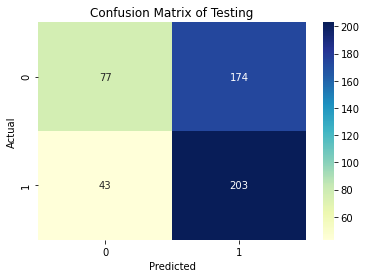

4/4 - 0s - loss: 0.6877 - acc: 0.5772 - val_loss: 0.6904 - val_acc: 0.5634
Epoch 6/20


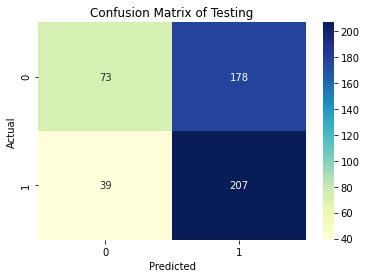

4/4 - 0s - loss: 0.6866 - acc: 0.6032 - val_loss: 0.6901 - val_acc: 0.5634
Epoch 7/20


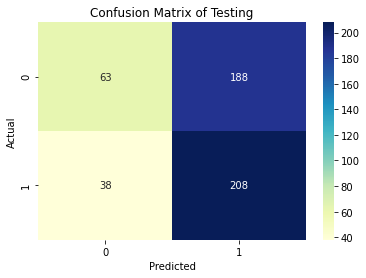

4/4 - 0s - loss: 0.6856 - acc: 0.6132 - val_loss: 0.6900 - val_acc: 0.5453
Epoch 8/20


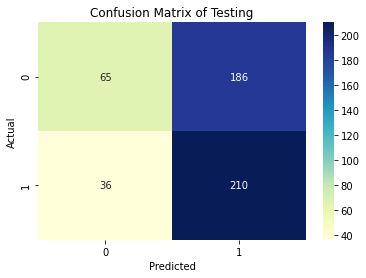

4/4 - 0s - loss: 0.6845 - acc: 0.6273 - val_loss: 0.6898 - val_acc: 0.5533
Epoch 9/20


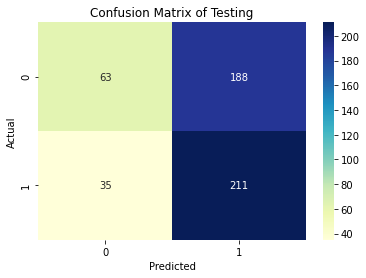

4/4 - 0s - loss: 0.6835 - acc: 0.6493 - val_loss: 0.6897 - val_acc: 0.5513
Epoch 10/20


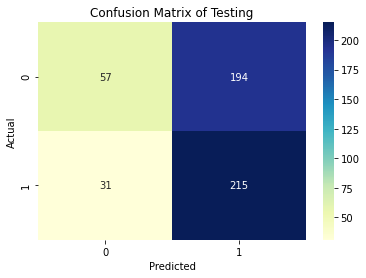

4/4 - 0s - loss: 0.6825 - acc: 0.6453 - val_loss: 0.6895 - val_acc: 0.5473
Epoch 11/20


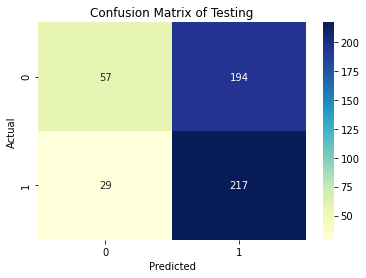

4/4 - 0s - loss: 0.6814 - acc: 0.6533 - val_loss: 0.6893 - val_acc: 0.5513
Epoch 12/20


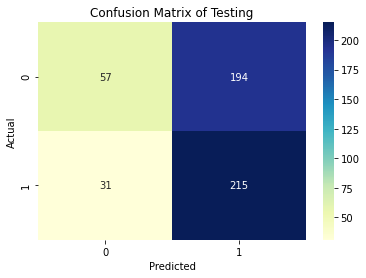

4/4 - 0s - loss: 0.6804 - acc: 0.6593 - val_loss: 0.6892 - val_acc: 0.5473
Epoch 13/20


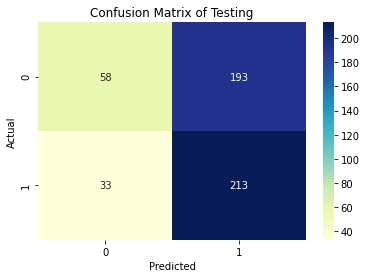

4/4 - 0s - loss: 0.6794 - acc: 0.6693 - val_loss: 0.6890 - val_acc: 0.5453
Epoch 14/20


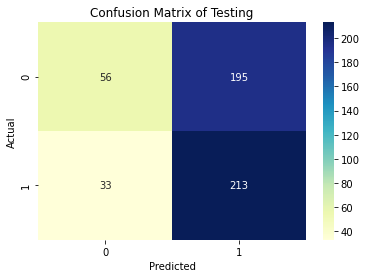

4/4 - 0s - loss: 0.6785 - acc: 0.6733 - val_loss: 0.6889 - val_acc: 0.5412
Epoch 15/20


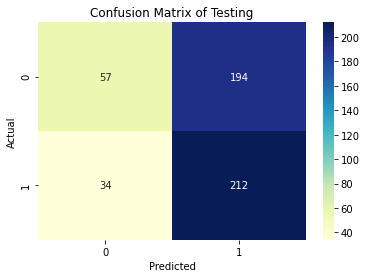

4/4 - 0s - loss: 0.6775 - acc: 0.6733 - val_loss: 0.6887 - val_acc: 0.5412
Epoch 16/20


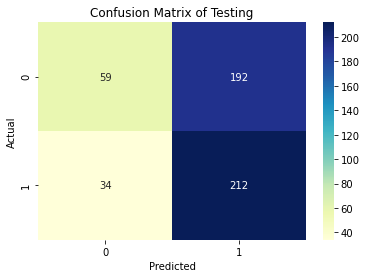

4/4 - 0s - loss: 0.6765 - acc: 0.6794 - val_loss: 0.6886 - val_acc: 0.5453
Epoch 17/20


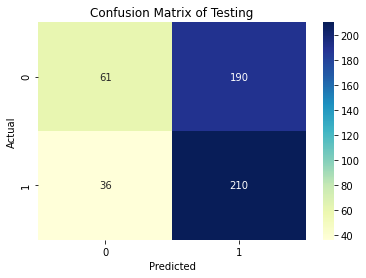

4/4 - 0s - loss: 0.6755 - acc: 0.6814 - val_loss: 0.6884 - val_acc: 0.5453
Epoch 18/20


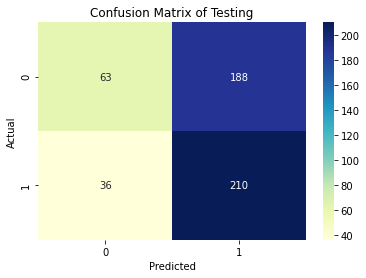

4/4 - 0s - loss: 0.6745 - acc: 0.6814 - val_loss: 0.6883 - val_acc: 0.5493
Epoch 19/20


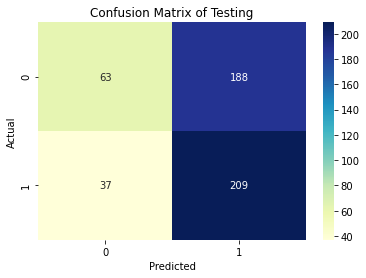

4/4 - 0s - loss: 0.6735 - acc: 0.6934 - val_loss: 0.6881 - val_acc: 0.5473
Epoch 20/20


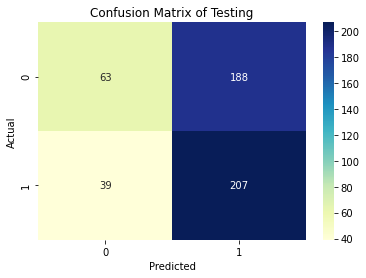

4/4 - 0s - loss: 0.6725 - acc: 0.6974 - val_loss: 0.6880 - val_acc: 0.5433
16/16 [==============================] - 0s 657us/step - loss: 0.6880 - acc: 0.5433


In [12]:


# Sequential model has layers added to it to develop it
model = Sequential()

# Embedding layer will give each input from the training set a vector of size
# 100.This is a process that allows us to take a 'discrete' vocabulary, and 
# try to map this data to higher dimensions. 
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen , trainable=False)
# Why does the above layer have trainable as false? Wouldn't this prevent it
# from updating weights on the embedded vectors? True gives lower test score,
# higher test accuracy
model.add(embedding_layer)
# In order to attach a dense layer, it is required to first flatten the prior
# layer's output. Example: 4 vectors of 8 dimensions, would become a single
# 32 dimension vector.
model.add(Flatten())
# Creating dense layer, single dimension output, activation with sigmoid. 
model.add(Dense(1, activation='sigmoid'))

# Compiled for training
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

# Setting up Callback function for epoch updates of conf matrix
confusion_matrix_updates = ConfMatrixCallbackPlotter(
                                model=model,
                                validation_data=(X_test, y_test))

# Trains with training dataset, 128 samples per batch, 20 epochs.
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=2 , validation_data=(X_test, y_test), callbacks=[confusion_matrix_updates])
score = model.evaluate(X_test, y_test, verbose=1)
# print("Test Score:", score[0])
# print("Test Accuracy:", score[1])




In [13]:


testingPredictions = (model.predict(X_test) > 0.5).astype("int32")
# print(testingPredictions)
yhat_probabilities = model.predict(X_test > 0.5, batch_size=128)
# print(yhat_probabilities)
target_names = ['negative', 'positive']
# print(classification_report(testingLabels, testingPredictions, target_names=target_names))

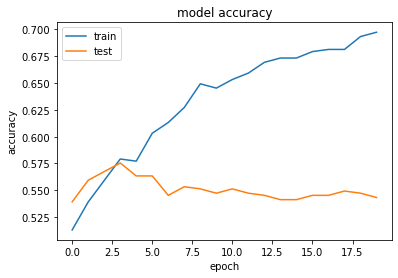

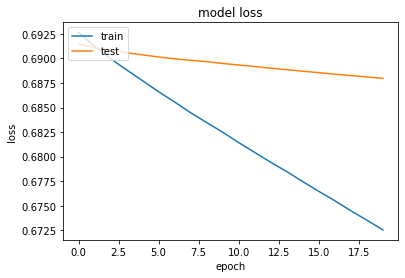

In [14]:


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

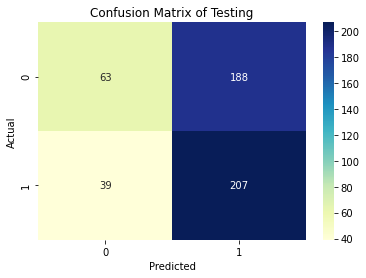

In [15]:
data = {'Actual':    testingLabels,
        'Predicted': testingPredictions.reshape(len(testingLabels),)
        }
#print(testingLabels.reshape(len(testingLabels),1))
df = pd.DataFrame(data, columns=['Actual','Predicted'])
confusion_matrix = pd.crosstab(df['Actual'], df['Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True,cmap="YlGnBu", fmt='d').set_title('Confusion Matrix of Testing')
plt.show()
# It appears that 1 is predicted much too frequently

In [16]:
import json

output_filename = 'neural_net_prediction.json'

data = []
for i in range(len(testingPredictions)):
  data.append({
      'index': i,
      'true_label': int(testingLabels[i]),
      'predicted_label': int(testingPredictions[i]),
      'confidence_score': yhat_probabilities.tolist()[i],
      'text': testingSentences[i]
  })

with open(output_filename, 'w') as outfile:
    json.dump(data, outfile, indent=4, sort_keys=False)
# Confidence Scores consistently weak at around .53
    
# from google.colab import files
# files.download('predict.json')



######################### dont run below cells ################################################

# D3 Confusion Matrix

In [17]:
from IPython.core.display import display, HTML
from string import Template


json_filepath = "\"" + output_filename + "\""
HTML('<script src="https://d3js.org/d3.v3.min.js" charset="utf-8"></script>')

In [18]:
css_text = '''
h1{
    color: black;
}
body {
    background-color: black;
    font-family: Arial, sans-serif;
    font-size: larger;
}
.box_highlighted { 
    background-color: #ffb; 
    border: 1px solid #b53;
}
.highlight{
    background-color: yellow;
}
.lighthigh{
    background-color: green;
}
li{
    font-size: smaller;
}
td{
    min-width: 100px;
}
#review{
    border:1px solid pink; 
    padding: 5px; 
    float: left; 
    width: 750px; 
    height: 500px; 
    background-color: white;
    color: black;
    margin: 20px;
    overflow: scroll;
}
#matrix{
    border:1px solid pink; 
    background-color: black;
    padding: 5px; 
    float: left;
    width: 750px; 
    height: 500px;
    margin: 20px;
    overflow: scroll;
}
'''

In [19]:
js_template = Template('''

console.log("Loading JavaScript...")
var conf_data = $confusion_data

console.log("Loaded Data:")
d3.json( $conf_data_filepath, function(d) {
    console.log(d)
})

/* I've temporarily left out the 'getType' function, since the names of these
types are not included in the JSON file that is given to the JavaScript. More functionality can be incldued later to bring the names in as well as the raw data. Type will be represented by the given numeric identifier for now. */

/* extractTypes: identifies different types each data point can be identified
as, based off of the 'true_label' attribute in JSON file
given: JSON file
returns: dictionary of possible values for 'true_label' */
function extractTypes(data){
    var lookup = {};
    var items = data
    var result = [];

    for (var item, i=0; item = items[i++];){
        var name = item.true_label;

        if(!(name in lookup)){
            lookup[name] = 1;
            result.push(name);
        }
    }

    return lookup;
}

d3.json("neural_net_prediction.json", function(d) {
    console.log(d); // Ensuring that data is properly read in.
    console.log(Object.keys(extractTypes(d))); // Logging list of possible types

    // # of Categories x # of Categories Table
    tableDimension = Object.keys(extractTypes(d)).length
    var table = new Array(tableDimension);
    var dataset = [];
    for(var i=0; i<tableDimension; i++){
        table[i] = new Array(tableDimension);
        for(var j=0; j<tableDimension; j++){
            table[i][j] = 0;
        }
    }

    // Filling out table with prediction counts and recording dataset
    /* Code is currently dependent on JSON having the data points: 
    "true_label" and "predicted_label" */
    for(var i=0; i<d.length; i+=1){ // i+=1 or i++ ?
        table[parseInt(d[i]["true_label"])][parseInt(d[i]["predicted_label"])]+=1;
        dataset.push([d[i]["true_label"], d[i]["predicted_label"], d[i]["text"], d[i]["index"]]);
    }

    console.log(table); // Reporting current state of table values.

    var w = 750;
    var h = 750; // These are dimensions?

    // Create SVG element
    var svg = d3.select("body") // This could be problematic later
                .select("#matrix")
                .append("svg")
                .attr("width", w)
                .attr("height", h);

    var rect = svg.selectAll("rect")
                  .data(dataset)
                  .enter()
                  .append("rect");

    // Give these a more descriptive name later
    var counters = new Array(tableDimension * tableDimension).fill(0);
    var ycounters = new Array(tableDimension * tableDimension).fill(0);

    var confusing = h / tableDimension;

    // JSON Object Format Guide: 
    // d[0] = true_label ; d[1] = predicted_label ; d[2] = text
    rect.attr("x", function (d, i){
        var matrixnum = (parseInt(d[1]) * tableDimension) + parseInt(d[0]);
        var inmatrixcol = counters[matrixnum] % 12;

        counters[matrixnum]++;

        return 10 + (d[0] * confusing) + (inmatrixcol * 16);

        })
        .attr("y", function(d, i){
            var matricvol = d[1];
            var matrixnum = (parseInt(d[1] * tableDimension) + parseInt(d[0]));
            var hm = Math.floor(ycounters[matrixnum]/12);

            ycounters[matrixnum]++;

            return 10 + (d[1] * confusing) + (hm * 16);
        })
        .attr("id", function(d){
            return "rect" + d[3];
        })
        .attr("width", function(d){
            return 15;
        })
        .attr("height", function(d){
            return 15;
        })
        .attr("opacity", function(d){
            return .85;
        })
        .attr("fill", function(d){
            return ("pink");
        })
        .attr("class", function(d){
            predicted_label = "predicted_label_" + d[1];
            true_label = "true_label_" + d[0];

            return true_label + " " + predicted_label;
    });

    d3.select("#review")
        .select("testList")
        .selectAll("rect")
        .data(
            dataset.filter(d => d[0] != d[1]),
            function(d){
                return d[3];
            }
        )
        .enter()
        .append("li")
        .attr("id", function(d){
            return "text" + d[3];
        })
        .html(function(d){
            table = "<table><tr>"

            table += "<td> True: ";
            table += parseInt(d[0]); //getType(d[0]);
            table += "</td>"

            table += "<td> Predict: ";
            table += parseInt(d[1]); //getType(d[1]);
            table += "</td>"

            table += "<td>" + d[2].substr(0,200); + "</td>"
            table += "</tr> </table>"

            return  table;
    });

    rect.on("click", function(d_on){
        d3.select("#review")
            .select("#testList")
            .html("");

        if(!this.classList.contains("past")){
            d3.selectAll(".past")
                .attr("fill", "pink")
                .classed("past", false);

            d3.selectAll(".reclick")
                .attr("fill", "pink")
                .classed("reclick", false)
        }

        if(!this.classList.contains("reclick")){
            d3.selectAll(".reclick")
                .attr("fill", "pink")
                .classed("reclick", false);
        }

        d3.select(this);

        textId = "";
        x = "." + this.classList[0];
        y = "." + this.classList[1];
        test = x + y;

        x1 = x.charAt(x.length - 1);
        y1 = y.charAt(y.length - 1);

        if(this.classList.contains("past")){
            d3.select(this)
                .classed("reclick", true)
            Id = this.id;
            textId = "#text" + Id.substring(4);
        }

        d3.selectAll(test)
            .attr("fill", "purple")
            .classed("past", "true");

        d3.select("#review")
            .select("#testList")
            .selectAll("rect")
            .data(
                dataset
                    .filter(d => d[0] == x1)
                    .filter(d => d[1] == y1),
                    function(d){
                        return d[3];
                    }
            )
            .enter()
            .append("li")
            .attr("id", function(d){
                return "text" + d[3];
            })
            .html(function(d){
                table = "<table><tr>"

                table += "<td> True: ";
                table += parseInt(d[0]); //getType(d[0]);
                table += "</td>"

                table += "<td> Predict: ";
                table += parseInt(d[1]); //getType(d[1]);
                table += "</td>"

                table += "<td>" + d[2].substr(0,200); + "</td>"
                table += "</tr> </table>"

                return table;
        });

        d3.select("#review")
            .select("testList")
            .selectAll("li")
            .on("mouseover", function(d_on){
                d3.select(this)
                    .classed("lighthigh", true)
                    id = this.id;
                    rectId = "#rect" + id.substring(4);
                    d3.selectAll(rectId)
                        .attr("fill", "green");
            })
            .on("mouseout", function(d_on){
                d3.select(this)
                    .classed("lighthigh", false)
                    id = this.id;
                    rectId = "#rect" + id.substring(4);
                    d3.selectAll(rectId)
                        .attr("fill", "purple");
        });
    });

    d3.select("#review")
        .select("#testList")
        .selectAll("li")
        .on("mouseover", function(d_on){
            d3.select(this)
                .classed("lighthigh", true)
                id = this.id;
                rectId = "#rect" + id.substring(4);
                d3.selectAll(rectId)
                    .attr("fill", "green");
        })
        .on("mouseout", function(d_on){
            d3.select(this)
                .classed("lighthigh", false)
                id = this.id;
                rectId = "#rect" + id.substring(4);
                d3.selectAll(rectId)
                    .attr("fill", "pink");
    });
    });

''')

In [20]:
html_template = Template('''
<style> $css_text </style>
<h1> Interactive Confusion Matrix </h1>
<div id="matrix"> </div>
<div id="review">
    Data 
    <ul id = "testList"></ul>
</div>
<script> $js_text </script>
''')

In [21]:
js_text = js_template.substitute({'confusion_data': data,
                                  'conf_data_filepath': json_filepath})

HTML(html_template.substitute({'css_text': css_text, 'js_text': js_text}))

In [22]:
# # this model uses pre-trained Word2Vec from Google
# import gensim
# from gensim import models
# from gensim.models import Word2Vec

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers import Embedding
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D

# # train word2vec model
# model = Word2Vec(train_words, size=100, window=5, workers=8, min_count=1)
# # summarize vocabulary size in model
# words = list(model.wv.vocab)
# print(words)
# print('Vocabulary size: %d' % len(words))

# filename = 'embedding_word2vec.txt'
# model.wv.save_word2vec_format(filename, binary=False)

# # load embedding as a dict
# def load_embedding(filename):
# 	# load embedding into memory, skip first line
# 	file = open(filename,'r')
# 	lines = file.readlines()[1:]
# 	file.close()
# 	# create a map of words to vectors
# 	embedding = dict()
# 	for line in lines:
# 		parts = line.split()
# 		# key is string word, value is numpy array for vector
# 		embedding[parts[0]] = asarray(parts[1:], dtype='float32')
# 	return embedding

# # create a weight matrix for the Embedding layer from a loaded embedding
# def get_weight_matrix(embedding, vocab):
# 	# total vocabulary size plus 0 for unknown words
# 	vocab_size = len(vocab) + 1
# 	# define weight matrix dimensions with all 0
# 	weight_matrix = zeros((vocab_size, 100))
# 	# step vocab, store vectors using the Tokenizer's integer mapping
# 	for word, i in vocab.items():
# 		weight_matrix[i] = embedding.get(word)
# 	return weight_matrix

# # load embedding from file
# raw_embedding = load_embedding('embedding_word2vec.txt')
# # get vectors in the right order
# embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# # create the embedding layer
# embedding_layer = Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=maxlen, trainable=False)

# model = Sequential()

# model.add(embedding_layer)

# model.add(Conv1D(128, 5, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# print(model2.summary())

# history = model2.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1)
# score = model2.evaluate(X_test, y_test, verbose=0)

# print("Test Accuracy:", score[1])

In [23]:
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])

# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train','test'], loc = 'upper left')
# plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','test'], loc = 'upper left')
# plt.show()

In [24]:
# def accuracy(predictions, actual):
#     return sum((predictions == actual)) / len(actual)

In [25]:
# train_confidence_scores, trainingPredictions = nbClassifier.predict(training)
# test_confidence_scores, testingPredictions = nbClassifier.predict(testing)



In [26]:
# def accuracy_button(arg):
#     print("Training accuracy:", accuracy(trainingPredictions, trainingLabels))
#     print("Testing accuracy:", accuracy(testingPredictions, testingLabels))

# button_download = widgets.Button(description = 'Model Accuracy')   
# button_download.on_click(accuracy_button)
# display(button_download)

In [27]:
# import pandas as pd
# import seaborn as sn
# import matplotlib.pyplot as plt

# data = {'Actual':    testingLabels,
#         'Predicted': testingPredictions
#         }

# df = pd.DataFrame(data, columns=['Actual','Predicted'])
# confusion_matrix = pd.crosstab(df['Actual'], df['Predicted'], rownames=['Actual'], colnames=['Predicted'])

# sn.heatmap(confusion_matrix, annot=True,cmap="YlGnBu").set_title('Confusion Matrix of Testing')
# plt.show()

In [28]:
# from sklearn.metrics import classification_report

# target_names = ['negative', 'positive']
# print(classification_report(testingLabels, testingPredictions, target_names=target_names))

In [29]:
# import json

# data = []
# for i in range(len(testingPredictions)):
#   data.append({
#       'index': i,
#       'true_label': int(testingLabels[i]),
#       'predicted_label': int(testingPredictions[i]),
#       'confidence_score': test_confidence_scores[i],
#       'text': testingSentences[i]
#   })

# with open('predcit.json', 'w') as outfile:
#     json.dump(data, outfile, indent=4, sort_keys=False)